In [2]:
import pandas as pd

df = pd.read_csv('/content/cleaned_aqi_data.csv')
display(df.head())

,Date,AQI
0,2018-07-02,44.375000
1,2018-07-03,56.650000
2,2018-07-04,53.681818
3,2018-07-05,62.875000
4,2018-07-06,50.916667


In [3]:
!pip install prophet streamlit pyngrok ngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 128.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.5 MB/s eta 0:00:00


In [4]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz
!tar xvzf ngrok-stable-linux-amd64.tgz
!mv ngrok /usr/local/bin

--2025-08-13 17:55:18--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 75.2.60.68, 13.248.244.96, 35.71.179.82, ...
Connecting to bin.equinox.io (bin.equinox.io)|75.2.60.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13856790 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.tgz’

ngrok-stable-linux- 100%[===================>]  13.21M  15.1MB/s    in 0.9s    

2025-08-13 17:55:20 (15.1 MB/s) - ‘ngrok-stable-linux-amd64.tgz’ saved [13856790/13856790]

ngrok


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.rename(columns={'AQI': 'y'})
df = df.rename_axis('ds')

Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_cleaned = df[(df['y'] >= lower_bound) & (df['y'] <= upper_bound)]

display(df_cleaned.head())

,y
ds,
2018-07-02,44.375000
2018-07-03,56.650000
2018-07-04,53.681818
2018-07-05,62.875000
2018-07-06,50.916667


In [6]:
from prophet import Prophet

df_cleaned_reset = df_cleaned.reset_index()
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(df_cleaned_reset)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkz29i9kp/jqcb9fqz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkz29i9kp/yyx575x5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56024', 'data', 'file=/tmp/tmpkz29i9kp/jqcb9fqz.json', 'init=/tmp/tmpkz29i9kp/yyx575x5.json', 'output', 'file=/tmp/tmpkz29i9kp/prophet_model1xou1kqa/prophet_model-20250813175521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [7]:
import numpy as np
from sklearn.metrics import mean_squared_error

future = model.make_future_dataframe(periods=0, include_history=True)
forecast = model.predict(future)
merged_df = pd.merge(df_cleaned_reset, forecast[['ds', 'yhat']], on='ds')

# Handle zero or negative values before log transformation
merged_df['y_log'] = merged_df['y'].apply(lambda x: np.log(x) if x > 0 else np.nan)
merged_df['yhat_log'] = merged_df['yhat'].apply(lambda x: np.log(x) if x > 0 else np.nan)

# Drop rows with NaN values resulting from log transformation
merged_df.dropna(subset=['y_log', 'yhat_log'], inplace=True)

rmse_log = np.sqrt(mean_squared_error(merged_df['y_log'], merged_df['yhat_log']))
print(f'RMSE on log-transformed values: {rmse_log}')

RMSE on log-transformed values: 0.31534464422303476


In [8]:
future = model.make_future_dataframe(periods=0, include_history=True)
forecast = model.predict(future)
merged_df = pd.merge(df_cleaned_reset, forecast[['ds', 'yhat']], on='ds')

# Handle zero or negative values before log transformation
merged_df['y_log'] = merged_df['y'].apply(lambda x: np.log(x) if x > 0 else np.nan)
merged_df['yhat_log'] = merged_df['yhat'].apply(lambda x: np.log(x) if x > 0 else np.nan)

# Drop rows with NaN values resulting from log transformation
merged_df.dropna(subset=['y_log', 'yhat_log'], inplace=True)

from sklearn.metrics import mean_squared_error
import numpy as np

rmse_log = np.sqrt(mean_squared_error(merged_df['y_log'], merged_df['yhat_log']))
print(f'RMSE on log-transformed values: {rmse_log}')

RMSE on log-transformed values: 0.31534464422303476


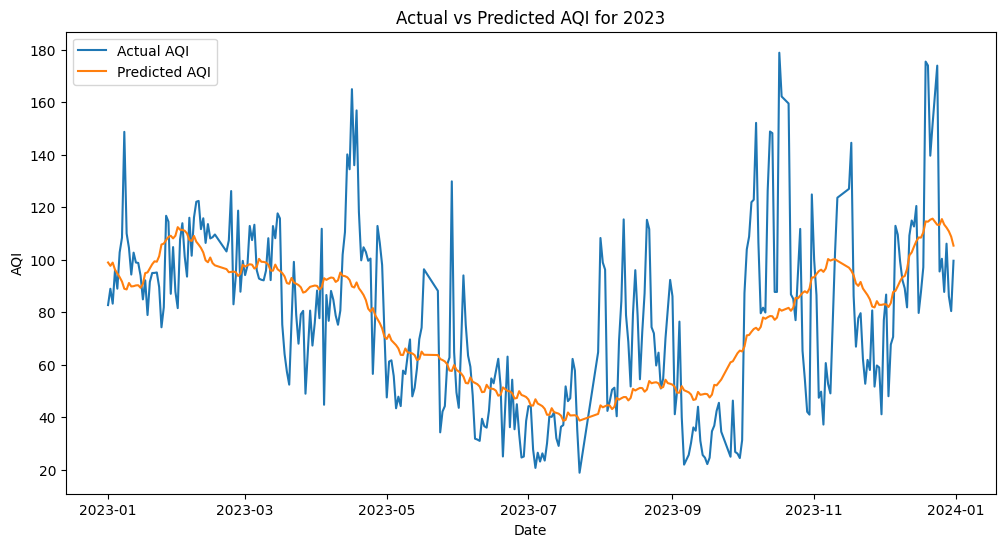

In [9]:
import matplotlib.pyplot as plt

merged_df['ds'] = pd.to_datetime(merged_df['ds'])
df_2023 = merged_df[merged_df['ds'].dt.year == 2023]

plt.figure(figsize=(12, 6))
plt.plot(df_2023['ds'], df_2023['y'], label='Actual AQI')
plt.plot(df_2023['ds'], df_2023['yhat'], label='Predicted AQI')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Actual vs Predicted AQI for 2023')
plt.legend()
plt.show()

In [10]:
import streamlit as st
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

In [11]:
!pip install streamlit

2025-08-13 17:55:31.795 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-13 17:55:32.088 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-08-13 17:55:32.091 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-13 17:55:32.091 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-13 17:55:32.092 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-13 17:55:32.094 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-13 17:55:32.096 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-13 17:55:32.099 Thread 'MainThread': mi

DeltaGenerator()

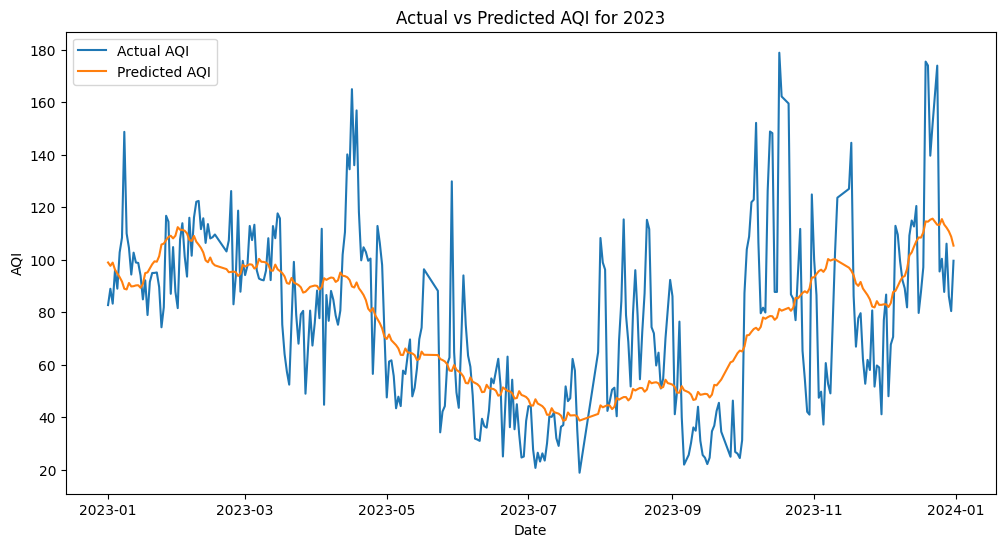

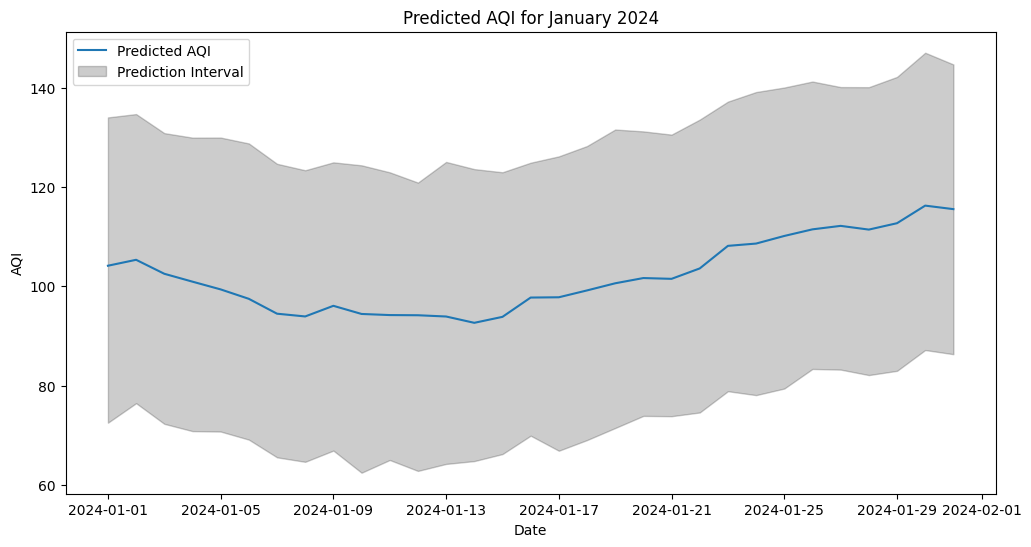

In [12]:
# Load the trained Prophet model
# In a real application, you would save and load the model
# For this example, we will re-train it quickly for demonstration purposes within the app script
# This is not ideal for performance but serves the purpose for this exercise
# In a production setting, train the model separately and load it here.
# Assuming df_cleaned_reset and model are available from previous steps

st.title('Air Quality Prediction with Prophet')

st.write("Select a month to predict the air quality.")

# Add a sidebar input for the user to select a month
month_input = st.selectbox(
    'Select Month (1-12)',
    range(1, 13)
)

# Generate future dates for prediction for the selected month in 2024
year_to_predict = 2024
future_dates = pd.date_range(start=f'{year_to_predict}-{month_input}-01', end=f'{year_to_predict}-{month_input}-{pd.Period(f"{year_to_predict}-{month_input}").days_in_month}', freq='D')
future = pd.DataFrame({'ds': future_dates})

# Generate predictions
future_forecast = model.predict(future)

st.subheader(f'Predicted AQI for {pd.to_datetime(f"{year_to_predict}-{month_input}-01").strftime("%B %Y")}')
st.write(future_forecast[['ds', 'yhat']].rename(columns={'ds': 'Date', 'yhat': 'Predicted AQI'}))


st.subheader('Actual vs Predicted AQI for 2023')

# Assuming df_2023 is available from previous steps
fig_2023, ax_2023 = plt.subplots(figsize=(12, 6))
ax_2023.plot(df_2023['ds'], df_2023['y'], label='Actual AQI')
ax_2023.plot(df_2023['ds'], df_2023['yhat'], label='Predicted AQI')
ax_2023.set_xlabel('Date')
ax_2023.set_ylabel('AQI')
ax_2023.set_title('Actual vs Predicted AQI for 2023')
ax_2023.legend()
st.pyplot(fig_2023)


st.subheader('Predicted AQI for the Selected Month')

fig_future, ax_future = plt.subplots(figsize=(12, 6))
ax_future.plot(future_forecast['ds'], future_forecast['yhat'], label='Predicted AQI')
ax_future.fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'], color='k', alpha=.2, label='Prediction Interval')
ax_future.set_xlabel('Date')
ax_future.set_ylabel('AQI')
ax_future.set_title(f'Predicted AQI for {pd.to_datetime(f"{year_to_predict}-{month_input}-01").strftime("%B %Y")}')
ax_future.legend()
st.pyplot(fig_future)

In [13]:
!streamlit run app.py &>/content/logs.txt &

In [14]:
streamlit_code = """
import streamlit as st
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# Load and prepare the data
df = pd.read_csv('/content/cleaned_aqi_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.rename(columns={'AQI': 'y'})
df = df.rename_axis('ds')

# Handle outliers using IQR
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_cleaned = df[(df['y'] >= lower_bound) & (df['y'] <= upper_bound)].copy() # Use .copy() to avoid SettingWithCopyWarning
df_cleaned_reset = df_cleaned.reset_index().copy() # Use .copy()

# Create a copy of the DataFrame with original 'y' values before log transformation for visualizations
df_original_y = df_cleaned_reset.copy()

# Apply log transformation to 'y' for training
df_cleaned_reset['y'] = df_cleaned_reset['y'].apply(lambda x: np.log1p(x) if x > 0 else np.nan)
df_cleaned_reset.dropna(subset=['y'], inplace=True) # Drop rows with NaN values after transformation


# Train the Prophet model on log-transformed data
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(df_cleaned_reset)

st.title('Air Quality Prediction with Prophet (Log Transformed)')

st.write("Select a year and month to predict the air quality.")

# Add sidebar inputs for year and month
year_input = st.selectbox(
    'Select Year for Prediction',
    range(2024, 2031) # Predicting a bit further out
)

month_input = st.selectbox(
    'Select Month for Prediction (1-12)',
    range(1, 13)
)

# Generate future dates for prediction for the selected month and year
future_dates_month = pd.date_range(start=f'{year_input}-{month_input}-01', end=f'{year_input}-{month_input}-{pd.Period(f"{year_input}-{month_input}").days_in_month}', freq='D')
future_month = pd.DataFrame({'ds': future_dates_month})

# Generate predictions
future_forecast_month = model.predict(future_month)

# Inverse transform the predictions
future_forecast_month['yhat'] = np.expm1(future_forecast_month['yhat'])
future_forecast_month['yhat_lower'] = np.expm1(future_forecast_month['yhat_lower'])
future_forecast_month['yhat_upper'] = np.expm1(future_forecast_month['yhat_upper'])


st.subheader(f'Predicted AQI for {pd.to_datetime(f"{year_input}-{month_input}-01").strftime("%B %Y")}')
st.write(future_forecast_month[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].rename(columns={'ds': 'Date', 'yhat': 'Predicted AQI', 'yhat_lower': 'Lower Bound', 'yhat_upper': 'Upper Bound'}))

# Display prediction interval information
mean_interval_width = (future_forecast_month['yhat_upper'] - future_forecast_month['yhat_lower']).mean() / 2
st.write(f"The prediction for the selected month can be off by approximately ±{mean_interval_width:.2f} AQI.")


# --- Historical vs Predicted AQI for a Selected Year ---
st.subheader(f'Historical vs Predicted AQI for {year_input}')

# Prepare data for the selected year's comparison plot (if historical data exists for that year)
# Need to inverse transform historical predictions as well for comparison
if year_input in df_original_y['ds'].dt.year.unique():
    future_year = model.make_future_dataframe(periods=0, include_history=True)
    forecast_year = model.predict(future_year)
    forecast_year['yhat'] = np.expm1(forecast_year['yhat']) # Inverse transform historical predictions

    # Merge with original historical data (not log-transformed 'y')
    merged_df_year = pd.merge(df_original_y[['ds', 'y']].rename(columns={'y': 'Actual AQI'}),
                              forecast_year[['ds', 'yhat']], on='ds')

    df_year = merged_df_year[merged_df_year['ds'].dt.year == year_input]

    fig_year, ax_year = plt.subplots(figsize=(12, 6))
    ax_year.plot(df_year['ds'], df_year['Actual AQI'], label='Actual AQI')
    ax_year.plot(df_year['ds'], df_year['yhat'], label='Predicted AQI')
    ax_year.set_xlabel('Date')
    ax_year.set_ylabel('AQI')
    ax_year.set_title(f'Actual vs Predicted AQI for {year_input}')
    ax_year.legend()
    st.pyplot(fig_year)
else:
    st.write(f'No historical data available for {year_input}. Showing predicted trend for the year.')
    # If predicting for a future year, show the predicted trend for the whole year
    future_dates_year = pd.date_range(start=f'{year_input}-01-01', end=f'{year_input}-12-31', freq='D')
    future_year_pred = pd.DataFrame({'ds': future_dates_year})
    forecast_year_pred = model.predict(future_year_pred)

    # Inverse transform future year predictions
    forecast_year_pred['yhat'] = np.expm1(forecast_year_pred['yhat'])
    forecast_year_pred['yhat_lower'] = np.expm1(forecast_year_pred['yhat_lower'])
    forecast_year_pred['yhat_upper'] = np.expm1(forecast_year_pred['yhat_upper'])


    fig_year_pred, ax_year_pred = plt.subplots(figsize=(12, 6))
    ax_year_pred.plot(forecast_year_pred['ds'], forecast_year_pred['yhat'], label='Predicted AQI')
    ax_year_pred.fill_between(forecast_year_pred['ds'], forecast_year_pred['yhat_lower'], forecast_year_pred['yhat_upper'], color='k', alpha=.2, label='Prediction Interval')
    ax_year_pred.set_xlabel('Date')
    ax_year_pred.set_ylabel('AQI')
    ax_year_pred.set_title(f'Predicted AQI for {year_input}')
    ax_year_pred.legend()
    st.pyplot(fig_year_pred)


st.subheader(f'Predicted AQI for {pd.to_datetime(f"{year_input}-{month_input}-01").strftime("%B %Y")}')

fig_month, ax_month = plt.subplots(figsize=(12, 6))
ax_month.plot(future_forecast_month['ds'], future_forecast_month['yhat'], label='Predicted AQI')
ax_month.fill_between(future_forecast_month['ds'], future_forecast_month['yhat_lower'], future_forecast_month['yhat_upper'], color='k', alpha=.2, label='Prediction Interval')
ax_month.set_xlabel('Date')
ax_month.set_ylabel('AQI')
ax_month.set_title(f'Predicted AQI for {pd.to_datetime(f"{year_input}-{month_input}-01").strftime("%B %Y")}')
ax_month.legend()
st.pyplot(fig_month)

st.subheader('Predicted AQI by Day (Selected Month)')

# Create a selectbox for the day within the chosen month
day_input = st.selectbox(
    'Select Day',
    range(1, future_forecast_month['ds'].dt.day.max() + 1)
)

# Filter the forecast for the selected day
selected_day_forecast = future_forecast_month[future_forecast_month['ds'].dt.day == day_input]

if not selected_day_forecast.empty:
    st.write(selected_day_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].rename(columns={'ds': 'Date', 'yhat': 'Predicted AQI', 'yhat_lower': 'Lower Bound', 'yhat_upper': 'Upper Bound'}))

    fig_day, ax_day = plt.subplots(figsize=(8, 4))
    ax_day.plot(selected_day_forecast['ds'], selected_day_forecast['yhat'], marker='o', linestyle='-', label='Predicted AQI')
    ax_day.fill_between(selected_day_forecast['ds'], selected_day_forecast['yhat_lower'], selected_day_forecast['yhat_upper'], color='k', alpha=.2, label='Prediction Interval')
    ax_day.set_xlabel('Date')
    ax_day.set_ylabel('AQI')
    ax_day.set_title(f'Predicted AQI for {pd.to_datetime(f"{year_input}-{month_input}-{day_input}").strftime("%B %d, %Y")}')
    ax_day.legend()
    st.pyplot(fig_day)
else:
    st.write("No data available for the selected day.")


# --- Weekly Analysis ---
st.subheader('Weekly Analysis')

# Group by week and calculate the mean predicted AQI
future_forecast_month['week'] = future_forecast_month['ds'].dt.isocalendar().week
weekly_avg_forecast = future_forecast_month.groupby('week')['yhat'].mean().reset_index()
weekly_avg_forecast['week'] = 'Week ' + weekly_avg_forecast['week'].astype(str)

st.write("Average Predicted AQI by Week for the Selected Month:")
st.write(weekly_avg_forecast)

fig_weekly, ax_weekly = plt.subplots(figsize=(10, 5))
ax_weekly.bar(weekly_avg_forecast['week'], weekly_avg_forecast['yhat'])
ax_weekly.set_xlabel('Week')
ax_weekly.set_ylabel('Average Predicted AQI')
ax_weekly.set_title(f'Average Predicted AQI by Week for {pd.to_datetime(f"{year_input}-{month_input}-01").strftime("%B %Y")}')
plt.xticks(rotation=45)
st.pyplot(fig_weekly)


# --- Multi-Line Graph (Overall AQI Trends with Selected Year Highlighted) ---
st.subheader('Overall AQI Trends with Selected Year Highlighted')
st.write("Multi-Line Graph: Displays AQI across all years in the dataset, highlighting the selected year.")

# Combine historical and forecasted data for the overall trend (using original scale)
# We need to generate predictions for the entire historical period to get the 'yhat' values
future_all_history = model.make_future_dataframe(periods=0, include_history=True)
forecast_all_history = model.predict(future_all_history)[['ds', 'yhat']]
forecast_all_history['yhat'] = np.expm1(forecast_all_history['yhat']) # Inverse transform historical predictions

# Merge with original historical data (not log-transformed 'y')
merged_df_all_history = pd.merge(df_original_y[['ds', 'y']].rename(columns={'y': 'Actual AQI'}),
                                 forecast_all_history[['ds', 'yhat']], on='ds')

merged_df_all_history['year'] = merged_df_all_history['ds'].dt.year

# Create a column to differentiate the selected year for highlighting
merged_df_all_history['highlight'] = merged_df_all_history['year'] == year_input

fig_multiline_overall = px.line(merged_df_all_history, x='ds', y='Actual AQI', color='highlight',
                                title='Overall AQI Trends with Selected Year Highlighted (Historical Data)')

# Add predicted line for the selected year if it's a historical year
if year_input in df_original_y['ds'].dt.year.unique():
     fig_multiline_overall.add_trace(go.Scatter(x=merged_df_all_history[merged_df_all_history['year'] == year_input]['ds'],
                                                y=merged_df_all_history[merged_df_all_history['year'] == year_input]['yhat'],
                                                mode='lines',
                                                name=f'Predicted AQI ({year_input})',
                                                line=dict(dash='dash')))

fig_multiline_overall.update_layout(xaxis_title='Date', yaxis_title='AQI')
st.plotly_chart(fig_multiline_overall)


# --- Donut Chart (AQI Category Distribution) ---
st.subheader('AQI Category Distribution')
st.write("A donut chart illustrating the distribution of different Air Quality Index (AQI) categories over the historical period.")

# Define AQI categories (example thresholds)
def get_aqi_category(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Satisfactory'
    elif aqi <= 200:
        return 'Moderate'
    elif aqi <= 300:
        return 'Poor'
    elif aqi <= 400:
        return 'Very Poor'
    else:
        return 'Severe'

# Apply category mapping to original historical data for the donut chart
df_original_y['AQI_Category'] = df_original_y['y'].apply(get_aqi_category)

category_counts = df_original_y['AQI_Category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

fig_donut = px.pie(category_counts, values='Count', names='Category', hole=.3, title='Distribution of AQI Categories')
st.plotly_chart(fig_donut)


# --- Heatmap (Annual Air Quality Insights) ---
st.subheader('Annual Air Quality Insights')
st.write("Heatmap displaying annual air quality insights, focusing on monthly AQI for 2025 and the number of days in different AQI categories from 2020 to 2025.")

# Monthly AQI for 2025 (using predicted values)
future_2025_monthly = pd.DataFrame({'ds': pd.date_range(start='2025-01-01', end='2025-12-31', freq='D')})
forecast_2025 = model.predict(future_2025_monthly)[['ds', 'yhat']]
forecast_2025['yhat'] = np.expm1(forecast_2025['yhat']) # Inverse transform 2025 monthly predictions
forecast_2025['month'] = forecast_2025['ds'].dt.month_name()
forecast_2025['year'] = forecast_2025['ds'].dt.year
monthly_avg_2025 = forecast_2025.groupby('month')['yhat'].mean().reset_index()
# Reorder months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_avg_2025['month'] = pd.Categorical(monthly_avg_2025['month'], categories=month_order, ordered=True)
monthly_avg_2025 = monthly_avg_2025.sort_values('month')


st.write("Average Predicted Monthly AQI for 2025:")
fig_heatmap_2025 = go.Figure(data=go.Heatmap(
        z=[monthly_avg_2025['yhat'].tolist()],
        x=monthly_avg_2025['month'].tolist(),
        y=['Average AQI'],
        colorscale='Hot',
        colorbar=dict(title='Average AQI')
    ))
fig_heatmap_2025.update_layout(title='Predicted Average Monthly AQI for 2025')
st.plotly_chart(fig_heatmap_2025)


# Number of days in each AQI category by year (2020-2025)
# Use original historical data (not log-transformed) for categories
historical_data_for_heatmap = df_original_y[df_original_y['ds'].dt.year >= 2020].copy()
historical_data_for_heatmap['year'] = historical_data_for_heatmap['ds'].dt.year
historical_data_for_heatmap['AQI_Category'] = historical_data_for_heatmap['y'].apply(get_aqi_category)


future_dates_2024_2025 = pd.date_range(start='2024-01-01', end='2025-12-31', freq='D')
future_df_2024_2025 = pd.DataFrame({'ds': future_dates_2024_2025})
forecast_2024_2025 = model.predict(future_df_2024_2025)[['ds', 'yhat']]
forecast_2024_2025['yhat'] = np.expm1(forecast_2024_2025['yhat']) # Inverse transform 2024-2025 predictions for category calculation
forecast_2024_2025['year'] = forecast_2024_2025['ds'].dt.year
forecast_2024_2025['AQI_Category'] = forecast_2024_2025['yhat'].apply(get_aqi_category)

combined_heatmap_data = pd.concat([
    historical_data_for_heatmap[['year', 'AQI_Category']],
    forecast_2024_2025[['year', 'AQI_Category']]
])

category_day_counts = combined_heatmap_data.groupby(['year', 'AQI_Category']).size().unstack(fill_value=0)

# Ensure all categories are present even if count is 0 for a year
all_categories = ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']
for category in all_categories:
    if category not in category_day_counts.columns:
        category_day_counts[category] = 0

category_day_counts = category_day_counts[all_categories] # Ensure consistent order

st.write("Number of Days in Each AQI Category (2020-2025):")
fig_heatmap_categories = go.Figure(data=go.Heatmap(
        z=category_day_counts.values.tolist(),
        x=category_day_counts.columns.tolist(),
        y=category_day_counts.index.tolist(),
        colorscale='Viridis',
        colorbar=dict(title='Number of Days')
    ))
fig_heatmap_categories.update_layout(title='Number of Days in Each AQI Category (2020-2025)',
                                     xaxis_title='AQI Category',
                                     yaxis_title='Year')
st.plotly_chart(fig_heatmap_categories)


# --- Trend Analysis (Highest and Lowest) ---
st.subheader('Trend Analysis')

# Find overall highest and lowest historical AQI (using original scale)
highest_aqi_hist = df_original_y['y'].max()
date_highest_hist = df_original_y[df_original_y['y'] == highest_aqi_hist]['ds'].iloc[0].strftime('%Y-%m-%d')
lowest_aqi_hist = df_original_y['y'].min()
date_lowest_hist = df_original_y[df_original_y['y'] == lowest_aqi_hist]['ds'].iloc[0].strftime('%Y-%m-%d')


st.write(f"**Highest Historical AQI:** {highest_aqi_hist:.2f} on {date_highest_hist}")
st.write(f"**Lowest Historical AQI:** {lowest_aqi_hist:.2f} on {date_lowest_hist}")

# Find highest and lowest predicted AQI for the selected year (using inverse transformed values)
if year_input not in df_original_y['ds'].dt.year.unique(): # Only show for future predicted years
    highest_aqi_pred_year = forecast_year_pred['yhat'].max()
    date_highest_pred_year = forecast_year_pred[forecast_year_pred['yhat'] == highest_aqi_pred_year]['ds'].iloc[0].strftime('%Y-%m-%d')
    lowest_aqi_pred_year = forecast_year_pred['yhat'].min()
    date_lowest_pred_year = forecast_year_pred[forecast_year_pred['yhat'] == lowest_aqi_pred_year]['ds'].iloc[0].strftime('%Y-%m-%d')
    st.write(f"**Highest Predicted AQI ({year_input}):** {highest_aqi_pred_year:.2f} on {date_highest_pred_year}")
    st.write(f"**Lowest Predicted AQI ({year_input}):** {lowest_aqi_pred_year:.2f} on {date_lowest_pred_year}")

# Find highest and lowest predicted AQI for the selected month (using inverse transformed values)
highest_aqi_pred_month = future_forecast_month['yhat'].max()
date_highest_pred_month = future_forecast_month[future_forecast_month['yhat'] == highest_aqi_pred_month]['ds'].iloc[0].strftime('%Y-%m-%d')
lowest_aqi_pred_month = future_forecast_month['yhat'].min()
date_lowest_pred_month = future_forecast_month[future_forecast_month['yhat'] == lowest_aqi_pred_month]['ds'].iloc[0].strftime('%Y-%m-%d')
st.write(f"**Highest Predicted AQI ({pd.to_datetime(f'{year_input}-{month_input}-01').strftime('%B %Y')}):** {highest_aqi_pred_month:.2f} on {date_highest_pred_month}")
st.write(f"**Lowest Predicted AQI ({pd.to_datetime(f'{year_input}-{month_input}-01').strftime('%B %Y')}):** {lowest_aqi_pred_month:.2f} on {date_lowest_pred_month}")


# --- Accuracy Information ---
st.subheader('Model Accuracy')

# Recalculate RMSE on log-transformed values within the app
# Ensure no zero or negative values before log transformation
df_cleaned_reset_for_accuracy = df_original_y.copy() # Use the original df for accuracy calculation
df_cleaned_reset_for_accuracy['y_log'] = df_cleaned_reset_for_accuracy['y'].apply(lambda x: np.log(x) if x > 0 else np.nan)
df_cleaned_reset_for_accuracy.dropna(subset=['y_log'], inplace=True)

forecast_history = model.predict(df_cleaned_reset_for_accuracy[['ds']])
forecast_history['yhat_log'] = forecast_history['yhat'].apply(lambda x: np.log(x) if x > 0 else np.nan) # Apply log transform to predictions for RMSE calculation


merged_accuracy_df = pd.merge(df_cleaned_reset_for_accuracy[['ds', 'y_log']], forecast_history[['ds', 'yhat_log']], on='ds').dropna()

from sklearn.metrics import mean_squared_error
rmse_log = np.sqrt(mean_squared_error(merged_accuracy_df['y_log'], merged_accuracy_df['yhat_log']))

st.write(f'Root Mean Squared Error (RMSE) on log-transformed values: {rmse_log:.4f}')
st.write("Note: RMSE on log-transformed values helps to evaluate model performance when there are large fluctuations or spikes in the data.")

"""

with open('app.py', 'w') as f:
    f.write(streamlit_code)

!streamlit run app.py &>/dev/null&

In [15]:
!pip install pyngrok

In [20]:
from pyngrok import ngrok
import os
import time

# Terminate open tunnels if any
ngrok.kill()

# Set your ngrok authtoken here. Replace 'YOUR_NGROK_AUTH_TOKEN' with your actual token.
# It's recommended to store this in environment variables for security.
# For this example, we'll set it directly.
ngrok_auth_token = os.environ.get("NGROK_AUTH_TOKEN", "YOUR_NGROK_AUTH_TOKEN") # Replace YOUR_NGROK_AUTH_TOKEN with your actual token
ngrok.set_auth_token('2tqLkAmewm6lJ8FR1w7QDzyLPYF_5ym1o2fHCn9tP6a2ibLQT')

# Open a tunnel to the Streamlit port 8501
public_url = ngrok.connect(addr='8501', proto='http')

print(f"Streamlit App Public URL: {public_url}")

# Keep the notebook running to keep the tunnel open.
# In a real application, you'd handle this differently.
# time.sleep(3600) # Keep the tunnel open for 1 hour (adjust as needed)

Streamlit App Public URL: NgrokTunnel: "https://ef2c32e769f0.ngrok-free.app" -> "http://localhost:8501"


In [22]:
ngrok.kill()

In [21]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# Load and prepare the data (recreating steps from the Streamlit app)
df = pd.read_csv('/content/cleaned_aqi_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.rename(columns={'AQI': 'y'})
df = df.rename_axis('ds')

# Handle outliers using IQR
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_cleaned = df[(df['y'] >= lower_bound) & (df['y'] <= upper_bound)].copy()
df_cleaned_reset = df_cleaned.reset_index().copy()

# Create a copy of the DataFrame with original 'y' values before log transformation
df_original_y = df_cleaned_reset.copy()

# Apply log transformation to 'y' for training
df_cleaned_reset['y'] = df_cleaned_reset['y'].apply(lambda x: np.log1p(x) if x > 0 else np.nan)
df_cleaned_reset.dropna(subset=['y'], inplace=True)

# Train the Prophet model on log-transformed data
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(df_cleaned_reset)

# --- Accuracy Information ---
# Recalculate RMSE on log-transformed values
# Ensure no zero or negative values before log transformation
df_cleaned_reset_for_accuracy = df_original_y.copy() # Use the original df for accuracy calculation
df_cleaned_reset_for_accuracy['y_log'] = df_cleaned_reset_for_accuracy['y'].apply(lambda x: np.log(x) if x > 0 else np.nan)
df_cleaned_reset_for_accuracy.dropna(subset=['y_log'], inplace=True)

forecast_history = model.predict(df_cleaned_reset_for_accuracy[['ds']])
forecast_history['yhat_log'] = forecast_history['yhat'].apply(lambda x: np.log(x) if x > 0 else np.nan) # Apply log transform to predictions for RMSE calculation

merged_accuracy_df = pd.merge(df_cleaned_reset_for_accuracy[['ds', 'y_log']], forecast_history[['ds', 'yhat_log']], on='ds').dropna()

rmse_log = np.sqrt(mean_squared_error(merged_accuracy_df['y_log'], merged_accuracy_df['yhat_log']))

print(f'Root Mean Squared Error (RMSE) on log-transformed values: {rmse_log:.4f}')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkz29i9kp/30uoarlp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkz29i9kp/mtaurqu4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54451', 'data', 'file=/tmp/tmpkz29i9kp/30uoarlp.json', 'init=/tmp/tmpkz29i9kp/mtaurqu4.json', 'output', 'file=/tmp/tmpkz29i9kp/prophet_modelbqe8082w/prophet_model-20250813180011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Squared Error (RMSE) on log-transformed values: 2.8069


In [23]:
%%writefile requirements.txt
pandas
prophet
streamlit
pyngrok
matplotlib
numpy
plotly
seaborn
sklearn

Writing requirements.txt
